### 3. unable 로 추가된 time 을 추가 및 재배열에 활용하기
- 3-1. intubationtime, intubationtime(un), extubationtime, extubationtime(un)이 포함된 테이블 읽기
- 3-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.
- 3-3. error 타입 정의하고 해결
- 3-4. pairing 및 seq 부여

#### 3-1. intubationtime, intubationtime_un, extubationtime, extubationtime_un 이 포함된 테이블 읽기

In [325]:
import pandas as pd
from dfply import *
import time
from tqdm import tqdm
import warnings

# CSV 파일 읽기, 날짜 컬럼 자동 파싱
unable_intu_extu = pd.read_csv('./data/unable_intu_extu.csv', 
                               encoding='utf-8-sig',
                               parse_dates=['intubationtime(un)', 'extubationtime(un)'])

print("Data loaded successfully. Shape:", unable_intu_extu.shape)
print("\nFirst few rows:")
print(unable_intu_extu.head())

Data loaded successfully. Shape: (17640, 13)

First few rows:
   subject_id   hadm_id   stay_id gender        los            admittime  \
0    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
1    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
2    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
3    10001884  26184834  37510196      F   9.171817  2131-01-07 20:39:00   
4    10003400  23559586  38383343      F  16.069838  2137-08-04 00:07:00   

   intubationtime(un)  extubationtime(un)  intu_extu_duration(period)  \
0 2131-01-11 08:00:00 2131-01-12 17:30:00                   33.500000   
1 2131-01-13 04:00:00 2131-01-13 20:00:00                   16.000000   
2 2131-01-14 08:08:00 2131-01-17 20:09:00                   84.016667   
3 2131-01-19 00:00:00 2131-01-19 08:00:00                    8.000000   
4 2137-08-18 02:00:00 2137-08-21 16:00:00                   86.000000   

   to_reintubation(un)  unableseq         

In [326]:
len(unable_intu_extu.subject_id.unique())

6397

<Figure size 2000x1000 with 0 Axes>

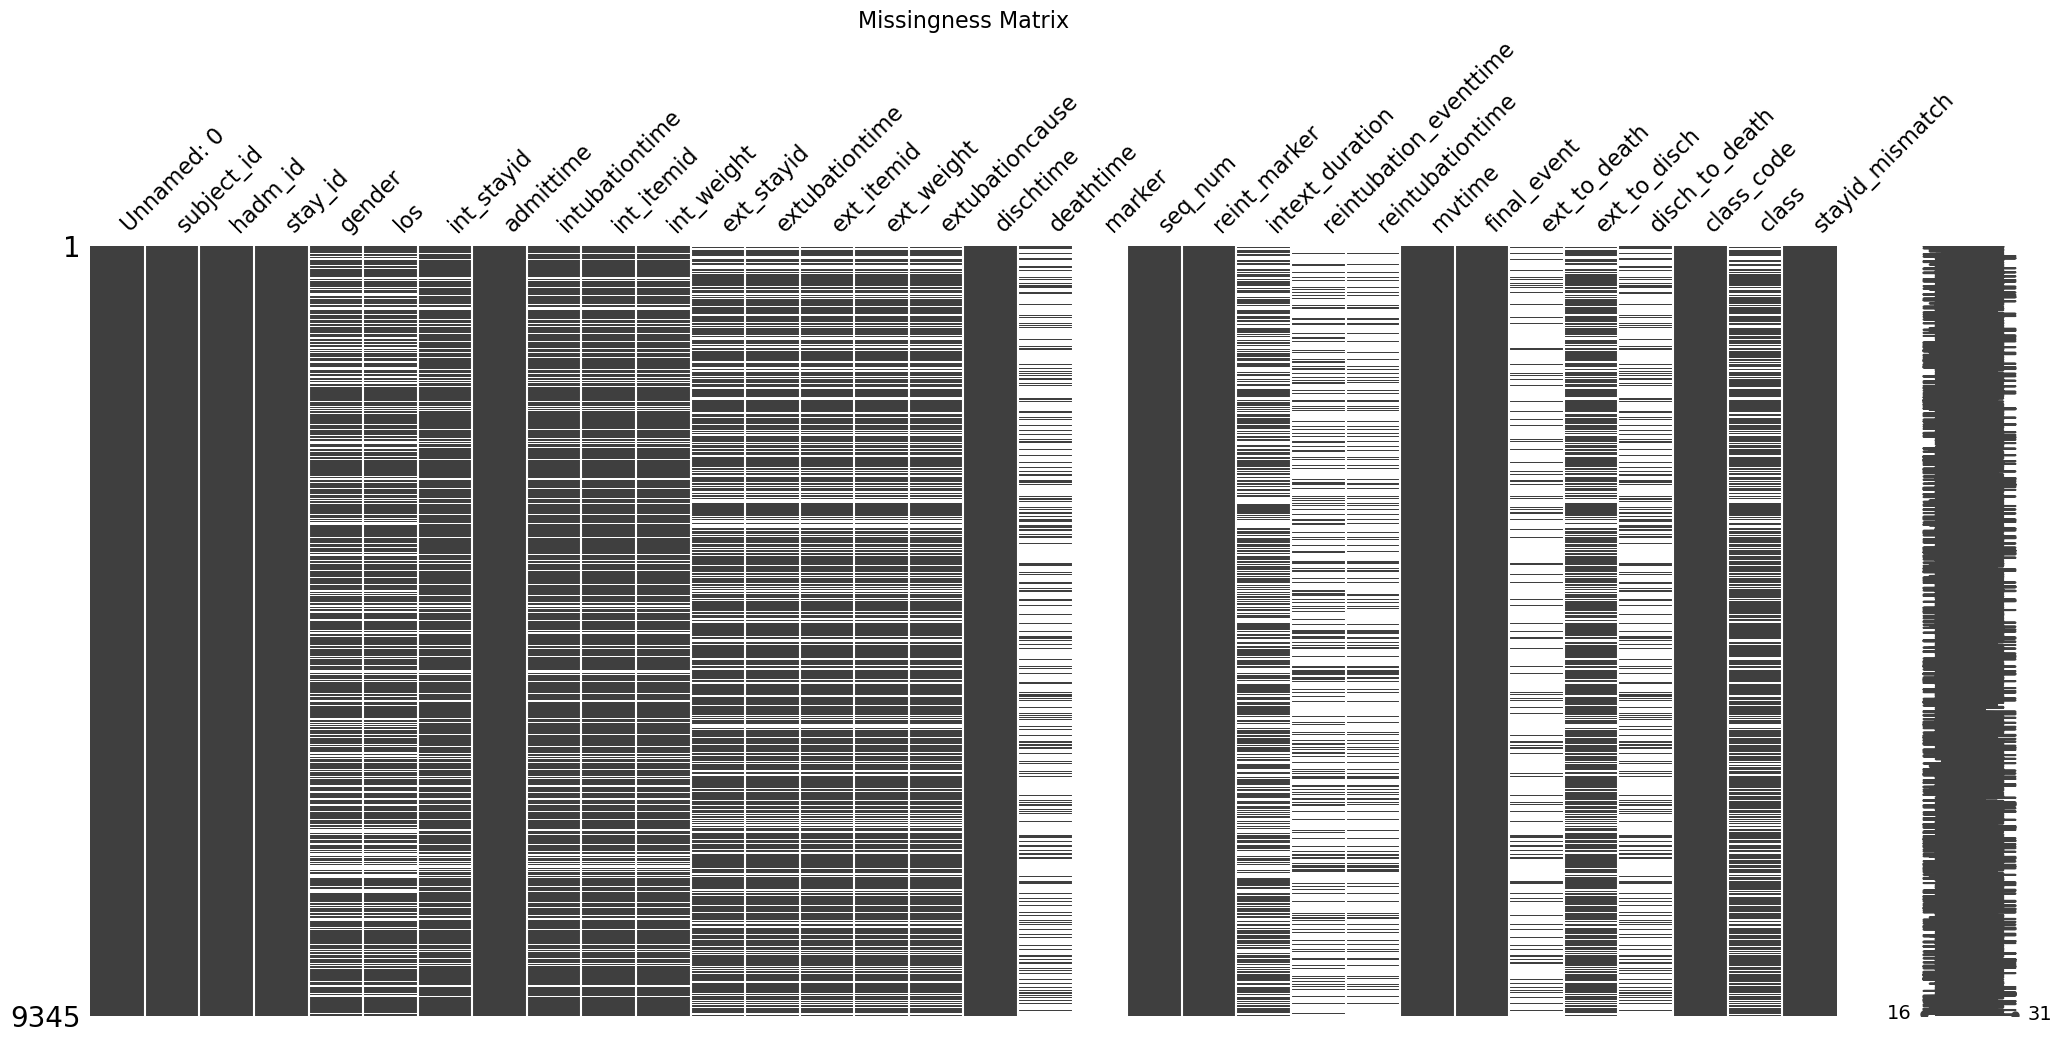

In [242]:
import missingno as msno
import matplotlib.pyplot as plt

# 00_subjectlist1_prepare02_alignment.ipynb 파일에서 최종적으로 저장되는 파일을 불러옴.
before_reconstruction = pd.read_csv('./data/subjectlist2_intextevents.csv', parse_dates=['admittime','intubationtime','extubationtime',\
                                    'dischtime','reintubation_eventtime','deathtime'])

# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(before_reconstruction)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

#### 3-2. intubation-extubation 은 pairing 되어야 하므로 연속해서 intubation event가 있거나 연속해서 extubation event 가 있으면 에러로 볼 수 있음.


In [243]:
import src_unable as pairing   # 삽관 발관 페어링 관련 모듈
from src_unable import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src_unable import flag   
from src_unable import subject_classification as cls
from src.utils import utils

In [244]:
before_reconstruction.info() # (9345, 32)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9345 entries, 0 to 9344
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              9345 non-null   int64         
 1   subject_id              9345 non-null   int64         
 2   hadm_id                 9345 non-null   int64         
 3   stay_id                 9345 non-null   int64         
 4   gender                  7071 non-null   object        
 5   los                     7071 non-null   float64       
 6   int_stayid              8057 non-null   float64       
 7   admittime               9345 non-null   datetime64[ns]
 8   intubationtime          8057 non-null   datetime64[ns]
 9   int_itemid              8057 non-null   float64       
 10  int_weight              8057 non-null   float64       
 11  ext_stayid              6969 non-null   float64       
 12  extubationtime          6969 non-null   datetime

In [245]:
# flag 생성
table = flag.add_columns(before_reconstruction, unable_intu_extu) # 원본 intuextu 페어링, unable intuextu | 비교에 필요한 컬럼 생성
table = flag.drop_duplication(table) # flag 생성 전 중복 데이터 삭제(모든 컬럼의 값이 동일한 행같은 경우)
table = flag.alignment_intuextu(table) # 정렬 (삽/발관 시간이 같은 경우 intubation이 먼저 나옴)
table = flag.duplicates_row_flag(table) # 연속해서 intubation이 있거나 extubation이 연속해서 있는 경우 dup_flag 생성
table = flag.time_diff(table) # dup_flag인 행과 그 다음 행의 시간 차이 계산

c:\Users\inhae\Desktop\extubationfailure\after2\src_unable\flag.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intubation_df['data_type']='real'
c:\Users\inhae\Desktop\extubationfailure\after2\src_unable\flag.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extubation_df['data_type']='real'
c:\Users\inhae\Desktop\extubationfailure\after2\src_unable\flag.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

#### 3-3. error 타입 정의하고 해결


In [327]:
print(f'intubation or extubation 중복인 경우: {round(table[table.dup_flag].shape[0] / table.shape[0] * 100, 2)}%')
print()
print(table.info()) # (49485, 9)
table

intubation or extubation 중복인 경우: 0.0%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42816 entries, 0 to 42815
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   subject_id       42816 non-null  int64          
 1   hadm_id          42816 non-null  int64          
 2   stay_id          42816 non-null  int64          
 3   time             42816 non-null  datetime64[ns] 
 4   data_type        42816 non-null  object         
 5   event_type       42816 non-null  object         
 6   extubationcause  6739 non-null   object         
 7   dup_flag         42816 non-null  bool           
 8   time_diff        0 non-null      timedelta64[ns]
 9   delete           42816 non-null  bool           
 10  add_extu         42816 non-null  bool           
 11  add_intu         42816 non-null  bool           
dtypes: bool(4), datetime64[ns](1), int64(3), object(3), timedelta64[ns](1)
memory usage: 2.8+ M

,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu,add_intu
0,10001884,26184834,37510196,2131-01-11 04:30:00,real,intubation,NaN,False,NaT,False,False,False
1,10001884,26184834,37510196,2131-01-12 17:40:00,real,extubation,Planned Extubation,False,NaT,False,False,False
2,10001884,26184834,37510196,2131-01-13 04:00:00,unable,intubation,NaN,False,NaT,False,False,False
3,10001884,26184834,37510196,2131-01-13 20:00:00,unable,extubation,NaN,False,NaT,False,False,False
4,10001884,26184834,37510196,2131-01-14 08:08:00,unable,intubation,NaN,False,NaT,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
42811,19999442,26785317,32336619,2148-11-20 14:15:00,real,extubation,Planned Extubation,False,NaT,False,False,False
42812,19999840,21033226,38978960,2164-09-12 09:40:00,real,intubation,NaN,False,NaT,False,False,False
42813,19999840,21033226,38978960,2164-09-12 16:00:00,unable,extubation,NaN,False,NaT,False,False,False
42814,19999840,21033226,38978960,2164-09-13 04:05:00,unable,intubation,NaN,False,NaT,False,False,False


In [249]:
def duplicate_intu(table):
    table.time_diff = pd.to_timedelta(table.time_diff)

    # intubation & 중복인 경우
    table_intu_dup = table[(table.event_type == 'intubation') & (table.dup_flag)]
    intu_mean = table[(table.event_type == 'intubation')].time_diff.mean()

    table['delete'] = False
    table['add_extu'] = False

    delete_idx = []

    for idx, row in table_intu_dup.iterrows():
        group = []
        next_idx = idx + 1

        # 3개 이상의 행이 중복인 경우
        if idx in delete_idx:
            pre_idx = idx - 1
            next_idx = idx + 1
            table.loc[[pre_idx, next_idx]]

            # time_diff(3시간 30분)가 평균보다 작은 경우
            if (table.loc[[pre_idx, next_idx]].time.diff() <= intu_mean).any():

                # data_type이 다른 경우는 삭제(unable intu - 원본 intu | 원본 intu - unable intu)
                if (table.loc[pre_idx].data_type != table.loc[next_idx]).data_type:
                    group.append({"index": pre_idx,"data_type": table.loc[pre_idx].data_type})
                    group.append({"index": next_idx,"data_type": table.loc[next_idx].data_type})
                    dataframe = pd.DataFrame(group)

                    cond_idx = dataframe[dataframe.data_type == 'unable']['index'].values[0]
                    table.loc[cond_idx,'delete'] = True

                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화
                else:
                    # 원본 intubation이 연달아 나오는 경우, extu 추가
                    if table.loc[pre_idx].data_type == 'real':

                        table.loc[next_idx,'add_extu'] = True
                        table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                        table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            else:
                # data_type에 관계없이 extu 추가
                table.loc[next_idx,'add_extu'] = True
                table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

        else:
            # time_diff(3시간 30분)가 평균보다 작은 경우
            if row.time_diff <= intu_mean: 
                # data_type이 다른 경우는 삭제(unable intu - 원본 intu | 원본 intu - unable intu)
                if row.data_type != table.loc[next_idx].data_type: 

                    group.append({"index": idx,"data_type": row.data_type})
                    group.append({"index": next_idx,"data_type": table.loc[next_idx].data_type})
                    dataframe = pd.DataFrame(group)

                    cond_idx = dataframe[dataframe.data_type == 'unable']['index'].values[0]
                    table.loc[cond_idx,'delete'] = True
                    delete_idx.append(cond_idx)
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화
                
                else:
                    # 원본 intubation이 연달아 나오는 경우, extu 추가
                    if row.data_type == 'real':

                        table.loc[next_idx,'add_extu'] = True
                        table.loc[idx,'dup_flag'] = False # flag 초기화
                        table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                    else:
                        print(row.hadm_id, 'unable이 두개 연속') # 아무것도 없어야 함

            # time_diff(3시간 30분)가 평균보다 큰 경우
            else:
                # data_type에 관계없이 extu 추가
                table.loc[next_idx,'add_extu'] = True
                table.loc[idx,'dup_flag'] = False # flag 초기화
                table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

    # extubation 추가
    table_copy = table[table.add_extu]

    table_copy.loc[:,'time'] = table_copy.time - pd.Timedelta(minutes = 1)
    table_copy.loc[:,'data_type'] = 'added'
    table_copy.loc[:,'event_type'] = 'extubation'
    table_copy.loc[:,'dup_flag'] = False
    table_copy.loc[:,'time_diff'] = pd.NaT

    table = pd.concat([table,table_copy]).sort_values(by=['hadm_id','stay_id','time'])#.reset_index(drop = True)

    # 조건에 맞는 행 삭제
    table = table[~(table.delete)]

    return table

####  extubaiton 추가 및 unable intubation 삭제 
- 뒤의 intubationtime -1분으로 extubation 추가
- delete 컬럼이 True인 행 삭제

In [250]:
table = duplicate_intu(table)
print(table.shape) # (45759, 11)
table[(table.event_type == 'intubation') & (table.dup_flag)] # 아무것도 안 나와야 함

(45759, 11)


,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu


- (B). extubation이 중복인 경우
- (B-1). 중복이 2개인 경우 (intubation - extubation - extubation 같이 2개의 extubation 연달아 나오는 경우)
    - 원본 extubation - unable extubation 순서인 경우
        - extubation이 Unplanned이면, intubation 추가
        - planned면, time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

    - unable extubation - 원본 extubatione 순서인 경우
        - time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

    - real extubation이 연달아 나오는 경우
        - 원래 extubation이 Unplanned이면, intubation 추가
        - planned면, time_diff가 평균시간(4시간)보다 작으면 unable 삭제, 크면 앞의 extubationtime +1분으로 intubation 추가

- (B-2) 중복이 3개
    - 위의 조건을 따름

In [251]:
def duplicate_extu(table):
    table.time_diff = pd.to_timedelta(table.time_diff)

    # extubation & 중복인 경우
    table_extu_dup = table[(table.event_type == 'extubation') & (table.dup_flag)]
    extu_mean = table[(table.event_type == 'extubation')].time_diff.mean()

    table['delete'] = False
    table['add_intu'] = False

    delete_idx= []

    for idx, row in table_extu_dup.iterrows():
        next_idx = idx + 1

        # 3개 이상의 행이 중복인 경우
        if idx in delete_idx:
            pre_idx = idx - 1
            next_idx = idx + 1
            pre_row = table.loc[pre_idx]
            next_row = table.loc[next_idx]

            # 1. real-unable인 경우 (real extubaion이 unplanned일 경우는 intubation 추가, 그외엔 평균시간에 따라 처리)
            if (pre_row.data_type == 'real') & (next_row.data_type == 'unable'):
                if isinstance(row.extubationcause, str) and 'Unplanned' in row.extubationcause:
                    table.loc[pre_idx,'add_intu'] = True

                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

                else:
                    # 평균시간(extu_mean)보다 작은 경우
                    if (table.loc[[pre_idx, next_idx]].time.diff() <= extu_mean).any():
                        table.loc[next_idx,'delete'] = True
                        table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                        table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

                    # 평균시간(extu_mean)보다 큰 경우
                    else:
                        table.loc[pre_idx,'add_intu'] = True
                        table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                        table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            # 2. unable - real인 경우 (평균시간보다 작은 경우는 unable extubation 삭제, 큰 경우는 intubation 추가)
            elif (pre_row.data_type == 'unable') & (next_row.data_type == 'real'):

                # 평균시간(extu_mean)보다 작은 경우
                if (table.loc[[pre_idx, next_idx]].time.diff() <= extu_mean).any():
                    table.loc[pre_idx,'delete'] = True
                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

                # 평균시간(extu_mean)보다 큰 경우
                else:
                    table.loc[pre_idx,'add_intu'] = True
                    table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                    table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            # 3. real extubation이 연달아 나오는 경우 (real - real, 삭제하지 않고 intubation 추가)
            elif (pre_row.data_type == 'real') & (next_row.data_type == 'real'):
                table.loc[pre_idx,'add_intu'] = True
                table.loc[pre_idx,'dup_flag'] = False # flag 초기화
                table.loc[pre_idx,'time_diff'] = pd.NaT # flag 초기화

            else:
                print(row.hadm_id) # 아무것도 안 나와야 함

        # 2개 행이 중복인 경우
        else:
            # 1. real-unable인 경우 (real extubaion이 unplanned일 경우는 intubation 추가, 그외엔 평균시간에 따라 처리)
            if (row.data_type == 'real') & (table.loc[next_idx].data_type == 'unable'):
                if isinstance(row.extubationcause, str) and 'Unplanned' in row.extubationcause:
                    table.loc[idx,'add_intu'] = True
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                else:
                    # 평균시간(extu_mean)보다 작은 경우
                    if row.time_diff <= extu_mean:
                        table.loc[next_idx,'delete'] = True
                        delete_idx.append(next_idx)
                        table.loc[idx,'dup_flag'] = False # flag 초기화
                        table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                    # 평균시간(extu_mean)보다 큰 경우
                    else:
                        table.loc[idx,'add_intu'] = True
                        table.loc[idx,'dup_flag'] = False # flag 초기화
                        table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

            # 2. unable - real인 경우 (평균시간보다 작은 경우는 unable extubation 삭제, 큰 경우는 intubation 추가)
            elif (row.data_type == 'unable') & (table.loc[next_idx].data_type == 'real'):
                
                # 평균시간(extu_mean)보다 작은 경우
                if row.time_diff <= extu_mean:
                    table.loc[idx,'delete'] = True
                    delete_idx.append(idx)
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

                # 평균시간(extu_mean)보다 큰 경우
                else:
                    table.loc[idx,'add_intu'] = True
                    table.loc[idx,'dup_flag'] = False # flag 초기화
                    table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

            # 3. real extubation이 연달아 나오는 경우 (real - real, 삭제하지 않고 intubation 추가)
            elif (row.data_type == 'real') & (table.loc[next_idx].data_type == 'real'):
                table.loc[idx,'add_intu'] = True
                table.loc[idx,'dup_flag'] = False # flag 초기화
                table.loc[idx,'time_diff'] = pd.NaT # flag 초기화

            else:
                print(row.hadm_id) # 아무것도 안 나와야 함

    # intubation 추가
    table_copy = table[table.add_intu]

    table_copy.loc[:,'time'] = table_copy.time + pd.Timedelta(minutes = 1)
    table_copy.loc[:,'data_type'] = 'added'
    table_copy.loc[:,'event_type'] = 'intubation'
    table_copy.loc[:,'dup_flag'] = False

    table_copy.loc[:,'time_diff'] = pd.NaT
    table_copy.loc[:,'extubationcause'] = None

    table = pd.concat([table,table_copy]).sort_values(by=['hadm_id','stay_id','time']).reset_index(drop = True)

    # 조건에 맞는 행 삭제
    table = table[~(table.delete)].reset_index(drop = True)

    return table

#### intubation 추가 및 unable extubation 삭제

In [252]:
table = duplicate_extu(table)
table[(table.event_type == 'extubation') & (table.dup_flag)] # 아무것도 안 나와야 함

table = flag.alignment_intuextu(table) # 재정렬
table = flag.duplicates_row_flag(table) # 오류 확인을 위해 새로운 flag 생성

print(table.shape) # (42816, 12)
table[(table.dup_flag)] # 최종 확인, 아무것도 안 나와야 함

,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu,add_intu


- (C). stay_id가 하나인 경우
- 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않음
- 따라서 icu 퇴실, 입실 시간으로 결측 행을 채움
- 그럼에도 채워지지 않는 행은 퇴원 시간으로 채움

In [254]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv', parse_dates = ['dischtime'])   # 성인 환자 정보
icustays = pd.read_csv('./data/icustays.csv', parse_dates = ['intime','outtime'])

In [255]:
# intubation으로 끝나는 경우
intu_last = table.groupby('stay_id').tail(1)[table.groupby('stay_id').tail(1).event_type == 'intubation']
# extubation으로 시작하는 경우
extu_first = table.groupby('stay_id').head(1)[table.groupby('stay_id').head(1).event_type == 'extubation']

list = []

# extubation이 없어 짝이 안 맞는 경우
for idx, row in intu_last.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu outtime이 마지막 행의 intubation 시간보다 클 때만 추가
    if (icu.outtime >= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.outtime.values[0],\
                     'data_type':'icu_out','event_type': 'extubation', 'dup_flag':False})
    else:
        # 
        dischtime = adults_icu[adults_icu.stay_id == row.stay_id].dischtime
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': dischtime.values[0],\
                     'data_type':'dischtime','event_type': 'extubation', 'dup_flag':False})

# intubation이 없어 짝이 안 맞는 경우
for idx, row in extu_first.iterrows():
    icu = icustays[icustays.stay_id == row.stay_id]

    # icu intime이 처음 행의 extubation 시간보다 작을 때만 추가
    if (icu.intime <= row.time).any():
        list.append({'subject_id': row.subject_id,'hadm_id': row.hadm_id,'stay_id': row.stay_id,'time': icu.intime.values[0],\
                     'data_type':'icu_in','event_type': 'intubation', 'dup_flag':False})
    else:
        print('추가할 intubation이 존재하지 않음(stay_id):', row.stay_id) # 아무것도 없어야 함

In [256]:
icu_data = pd.DataFrame(list)
final_table = pd.concat([table, icu_data])

final_table = flag.alignment_intuextu(final_table) # 재정렬
final_table = flag.duplicates_row_flag(final_table) # 오류 확인을 위해 새로운 flag 생성

print(final_table.shape) # ()
final_table[final_table.dup_flag] # 아무것도 없어야 함

,subject_id,hadm_id,stay_id,time,data_type,event_type,extubationcause,dup_flag,time_diff,delete,add_extu,add_intu


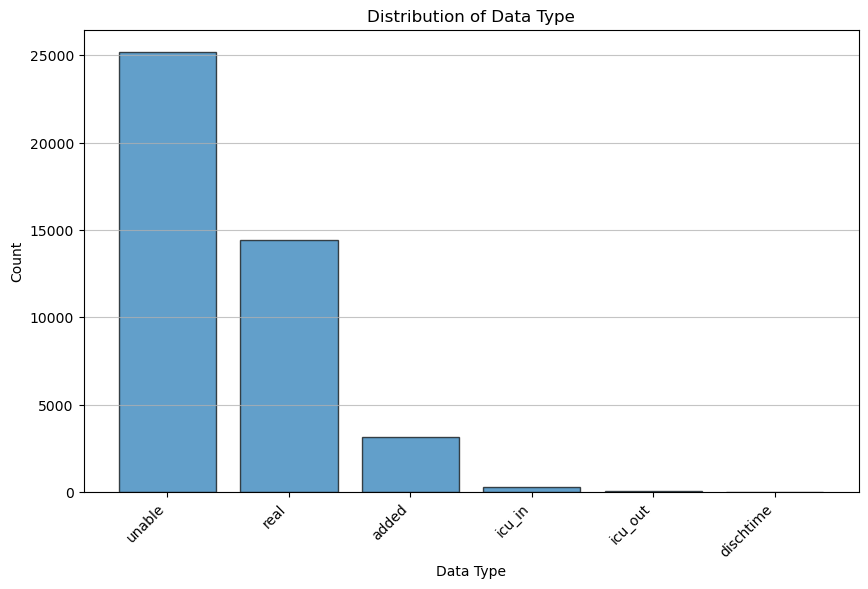

data_type
unable       25199
real         14445
added         3172
icu_in         289
icu_out         40
dischtime        1
Name: count, dtype: int64
Total: 43146


In [281]:
data_type_count = final_table.data_type.value_counts()

plt.figure(figsize=(10, 6))
plt.bar(data_type_count.index, data_type_count.values, edgecolor = 'k',alpha = 0.7)
plt.title('Distribution of Data Type')
plt.xlabel('Data Type')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right') 
plt.show()

print(data_type_count)
print(f'Total: {data_type_count.sum()}')

data type 설명
- unable   : gcs의 unable을 기준으로 생성한 삽/발관
- real     : 원본 삽/발관
- added    : duplicate_intu, duplicate_extu 함수로 생성된 삽/발관
- icu_in   : 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않아 icu 입실 시간으로 채움
- icu_out  : 참고할 unable 삽/발관과 원본 삽/발관이 존재하지 않아 icu 퇴실 시간으로 채움
- dischtime: icu 퇴실 시간이 없는 경우 퇴원 시각으로 채움

#### 3-4. pairing 및 seq 부여

- subjectlist2 : unableevents 를 추가하고, pairing 하고 seq부여하고, 이 과정에서 생기는 에러 해결
    - table에서 발생한 error를 모두(?) 해결
    - 테이블 완결을 위한 환자 관련 변수들 추가

In [222]:
# intubation, extubation 페어링
intubation_table = final_table[final_table.event_type == 'intubation'].rename(columns={'time':'intubationtime'})
extubation_table = final_table[final_table.event_type == 'extubation'].rename(columns = {'time':'extubationtime'})

# 테이블 시간 정렬
intubation_df = intubation_table.sort_values('intubationtime')
extubation_df = extubation_table.sort_values('extubationtime')

paired_df = pd.merge_asof(
    intubation_df,
    extubation_df,
    left_on='intubationtime',
    right_on='extubationtime',
    by=['subject_id', 'hadm_id', 'stay_id'],  # 같은 subject_id, hadm_id, stay_id 기준으로
    direction='forward'  # intubation 이후의 가장 가까운 extubation 시간과 페어링
)

final_table = paired_df[['subject_id','hadm_id','stay_id','intubationtime','extubationtime','data_type_x','data_type_y','extubationcause_y']]
final_table.rename(columns = {'data_type_x':'intu_data', 'data_type_y':'extu_data', 'extubationcause_y':'extubationcause'}, inplace = True)
final_table.sort_values(by = ['subject_id', 'hadm_id', 'stay_id','intubationtime'], inplace = True)
final_table.reset_index(drop = True, inplace = True)

C:\Users\inhae\AppData\Local\Temp\ipykernel_12744\1337356591.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table.rename(columns = {'data_type_x':'intu_data', 'data_type_y':'extu_data', 'extubationcause_y':'extubationcause'}, inplace = True)
C:\Users\inhae\AppData\Local\Temp\ipykernel_12744\1337356591.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_table.sort_values(by = ['subject_id', 'hadm_id', 'stay_id','intubationtime'], inplace = True)


In [297]:
print(f'before_reconstruction_row_count: {before_reconstruction.shape[0]}') 
print(f'subjectlist2_unable_row_count: {final_table.shape[0]}') # 약 10,000개 증가

before_reconstruction_row_count: 9345
subjectlist2_unable_row_count: 43146


In [324]:
print(len(before_reconstruction.subject_id.unique())) #6360
len(final_table.subject_id.unique())

6360


6397

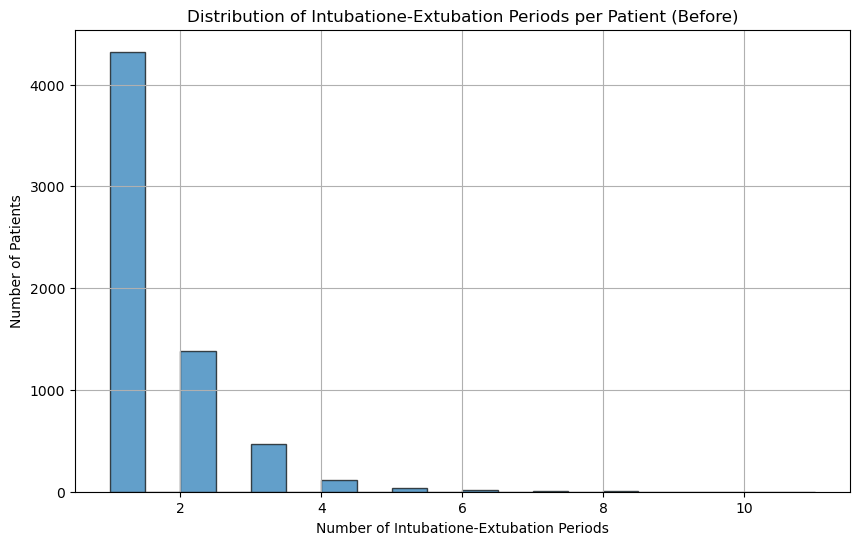

Before
count    6360.000000
mean        1.469340
std         0.832772
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: count, dtype: float64


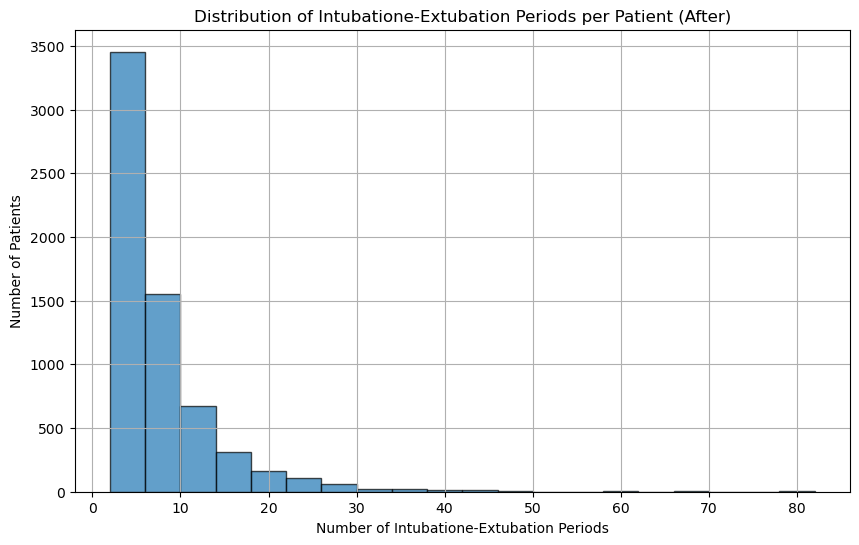

After
count    6397.000000
mean        6.744724
std         6.629337
min         2.000000
25%         2.000000
50%         4.000000
75%         8.000000
max        82.000000
Name: count, dtype: float64


In [320]:
# 환자별 삽/발관 횟수 분포

# 환자별 Intubatione-Extubaion(Before) 횟수 분포
patient_before_reconstruction_counts = before_reconstruction.subject_id.value_counts()
plt.figure(figsize=(10, 6))
patient_before_reconstruction_counts.hist(bins=20, edgecolor = 'k', alpha = 0.7)
plt.title('Distribution of Intubatione-Extubation Periods per Patient (Before)')
plt.xlabel('Number of Intubatione-Extubation Periods')
plt.ylabel('Number of Patients')
plt.show()

print('Before')
print(patient_before_reconstruction_counts.describe())


# 환자별 Intubatione-Extubaion(After) 횟수 분포
patient_final_table_counts = final_table.subject_id.value_counts()
plt.figure(figsize=(10, 6))
patient_final_table_counts.hist(bins=20, edgecolor = 'k', alpha = 0.7)
plt.title('Distribution of Intubatione-Extubation Periods per Patient (After)')
plt.xlabel('Number of Intubatione-Extubation Periods')
plt.ylabel('Number of Patients')
plt.show()

print('After')
print(patient_final_table_counts.describe())

- 성별 등 환자 정보 추가

In [224]:
# 환자 정보
patients_info = unable_intu_extu[['hadm_id','gender','los','admittime','dischtime','deathtime']].drop_duplicates(subset = ["hadm_id"])

# 칼럼 순서 변경
final_columns = ['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime', 
                 'intubationtime','extubationtime','extubationcause','intu_data','extu_data', 'dischtime','deathtime']

joined_df = pd.merge(patients_info, final_table, on = ['hadm_id'])[final_columns]
joined_df

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime,extubationtime,extubationcause,intu_data,extu_data,dischtime,deathtime
0,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-11 04:30:00,2131-01-12 17:40:00,Planned Extubation,real,real,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-13 04:00:00,2131-01-13 20:00:00,NaN,unable,unable,2131-01-20 05:15:00,2131-01-20 05:15:00
2,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-14 08:08:00,2131-01-17 20:09:00,NaN,unable,unable,2131-01-20 05:15:00,2131-01-20 05:15:00
3,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-19 00:00:00,2131-01-19 08:00:00,NaN,unable,unable,2131-01-20 05:15:00,2131-01-20 05:15:00
4,10003400,23559586,38383343,F,16.069838,2137-08-04 00:07:00,2137-08-17 21:21:00,2137-08-18 01:59:00,NaN,real,added,2137-09-02 17:05:00,2137-09-02 17:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21568,19999068,21606769,30143796,M,6.765324,2161-08-24 04:10:00,2161-08-27 19:30:00,2161-08-28 13:35:00,Planned Extubation,unable,real,2161-09-02 19:00:00,NaN
21569,19999442,26785317,32336619,M,6.950370,2148-11-19 10:00:00,2148-11-19 19:00:00,2148-11-19 22:59:00,NaN,real,added,2148-12-04 16:25:00,NaN
21570,19999442,26785317,32336619,M,6.950370,2148-11-19 10:00:00,2148-11-19 23:00:00,2148-11-20 14:15:00,Planned Extubation,unable,real,2148-12-04 16:25:00,NaN
21571,19999840,21033226,38978960,M,5.297766,2164-09-10 13:47:00,2164-09-12 09:40:00,2164-09-12 16:00:00,NaN,real,unable,2164-09-17 13:42:00,2164-09-17 13:42:00


- Reintubationtime  관련 변수들 계산, 데이터 정리

In [226]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['hadm_id', 'stay_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, mvtime, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.get_mvtime(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['hadm_id', 'stay_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [227]:
reintubation_unable = get_reintubation(joined_df)
reintubation_unable.info()

Fetching reintubation data...: 100%|██████████| 7339/7339 [00:21<00:00, 336.63it/s]


--- RUNTIME: 24.64 seconds ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21573 entries, 0 to 21572
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   subject_id              21573 non-null  int64         
 1   hadm_id                 21573 non-null  int64         
 2   stay_id                 21573 non-null  int64         
 3   gender                  21573 non-null  object        
 4   los                     21573 non-null  float64       
 5   admittime               21573 non-null  object        
 6   intubationtime          21573 non-null  datetime64[ns]
 7   extubationtime          21573 non-null  datetime64[ns]
 8   extubationcause         6739 non-null   object        
 9   intu_data               21573 non-null  object        
 10  extu_data               21573 non-null  object        
 11  dischtime               21573 non-null  object        
 12  deathtime      

In [228]:
reintubation_unable.to_csv('./data/reintubation_unable.csv')

- 환자군 분류 (ext failure, non-failure, etc.)

분류 코드
11 재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121 재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221 재삽관 없이 발관후 24시간 이내 사망 | death

1222 재삽관 없이 발관후 24~48시간 이내 사망 | death

211 48시간 이내 재삽관 | failure

212 48시간 너머 재삽관 | nonfailure

221 최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221 최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999 (null case)현발관-다음발관이 48시간 이내 | Failure

998 (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999 (null case) non-failure 판단 불가 | 제거

In [229]:
# 데이터 임포트
reintubation_unable = pd.read_csv('./data/reintubation_unable.csv', index_col=0, \
                               parse_dates=['intubationtime', 'extubationtime', \
                                            'admittime', 'dischtime', 'deathtime'])

print(reintubation_unable.shape)   # (21573, 18) 

(21573, 18)


In [230]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime_state, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [231]:
subjectlist2_unable = categorize_patients(reintubation_unable)

print(f'Processed subjectlist1: {subjectlist2_unable.shape}')   # (21573, 25)

subjectlist2_unable.columns

Categorizing extubation failure vs non-failure...: 100%|██████████| 6743/6743 [01:01<00:00, 110.36it/s]


--- RUNTIME: 64.15 seconds ---
Processed subjectlist1: (21573, 25)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'admittime',
       'intubationtime', 'extubationtime', 'extubationcause', 'intu_data',
       'extu_data', 'dischtime', 'deathtime', 'reint_marker', 'mvtime',
       'reintubation_eventtime', 'reintubationtime', 'seq_num', 'mvtime_state',
       'final_event', 'ext_to_death', 'ext_to_disch', 'disch_to_death',
       'class_code', 'class'],
      dtype='object')

In [232]:
subjectlist2_unable.head()

,subject_id,hadm_id,stay_id,gender,los,admittime,intubationtime,extubationtime,extubationcause,intu_data,...,reintubation_eventtime,reintubationtime,seq_num,mvtime_state,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-11 04:30:00,2131-01-12 17:40:00,Planned Extubation,real,...,2131-01-13 04:00:00,620.0,1,False,False,10775.0,10775.0,0.0,211,failure
1,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-13 04:00:00,2131-01-13 20:00:00,NaN,unable,...,2131-01-14 08:08:00,728.0,2,True,False,9195.0,9195.0,0.0,211,failure
2,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-14 08:08:00,2131-01-17 20:09:00,NaN,unable,...,2131-01-19 00:00:00,1671.0,3,False,False,3426.0,3426.0,0.0,211,failure
3,10001884,26184834,37510196,F,9.171817,2131-01-07 20:39:00,2131-01-19 00:00:00,2131-01-19 08:00:00,NaN,unable,...,NaN,NaN,4,True,True,1275.0,1275.0,0.0,22221,death
4,10003400,23559586,38383343,F,16.069838,2137-08-04 00:07:00,2137-08-17 21:21:00,2137-08-18 01:59:00,NaN,real,...,2137-08-18 02:00:00,1.0,1,True,False,22506.0,22506.0,0.0,211,failure


In [233]:
# 비논리적 데이터 삭제
subjectlist2_unable = subjectlist2_unable[((subjectlist2_unable.mvtime.isna()) | (subjectlist2_unable.mvtime > 0)) &\
              ((subjectlist2_unable.reintubationtime.isna()) | (subjectlist2_unable.reintubationtime >= 0))] # 1666

<Figure size 2000x1000 with 0 Axes>

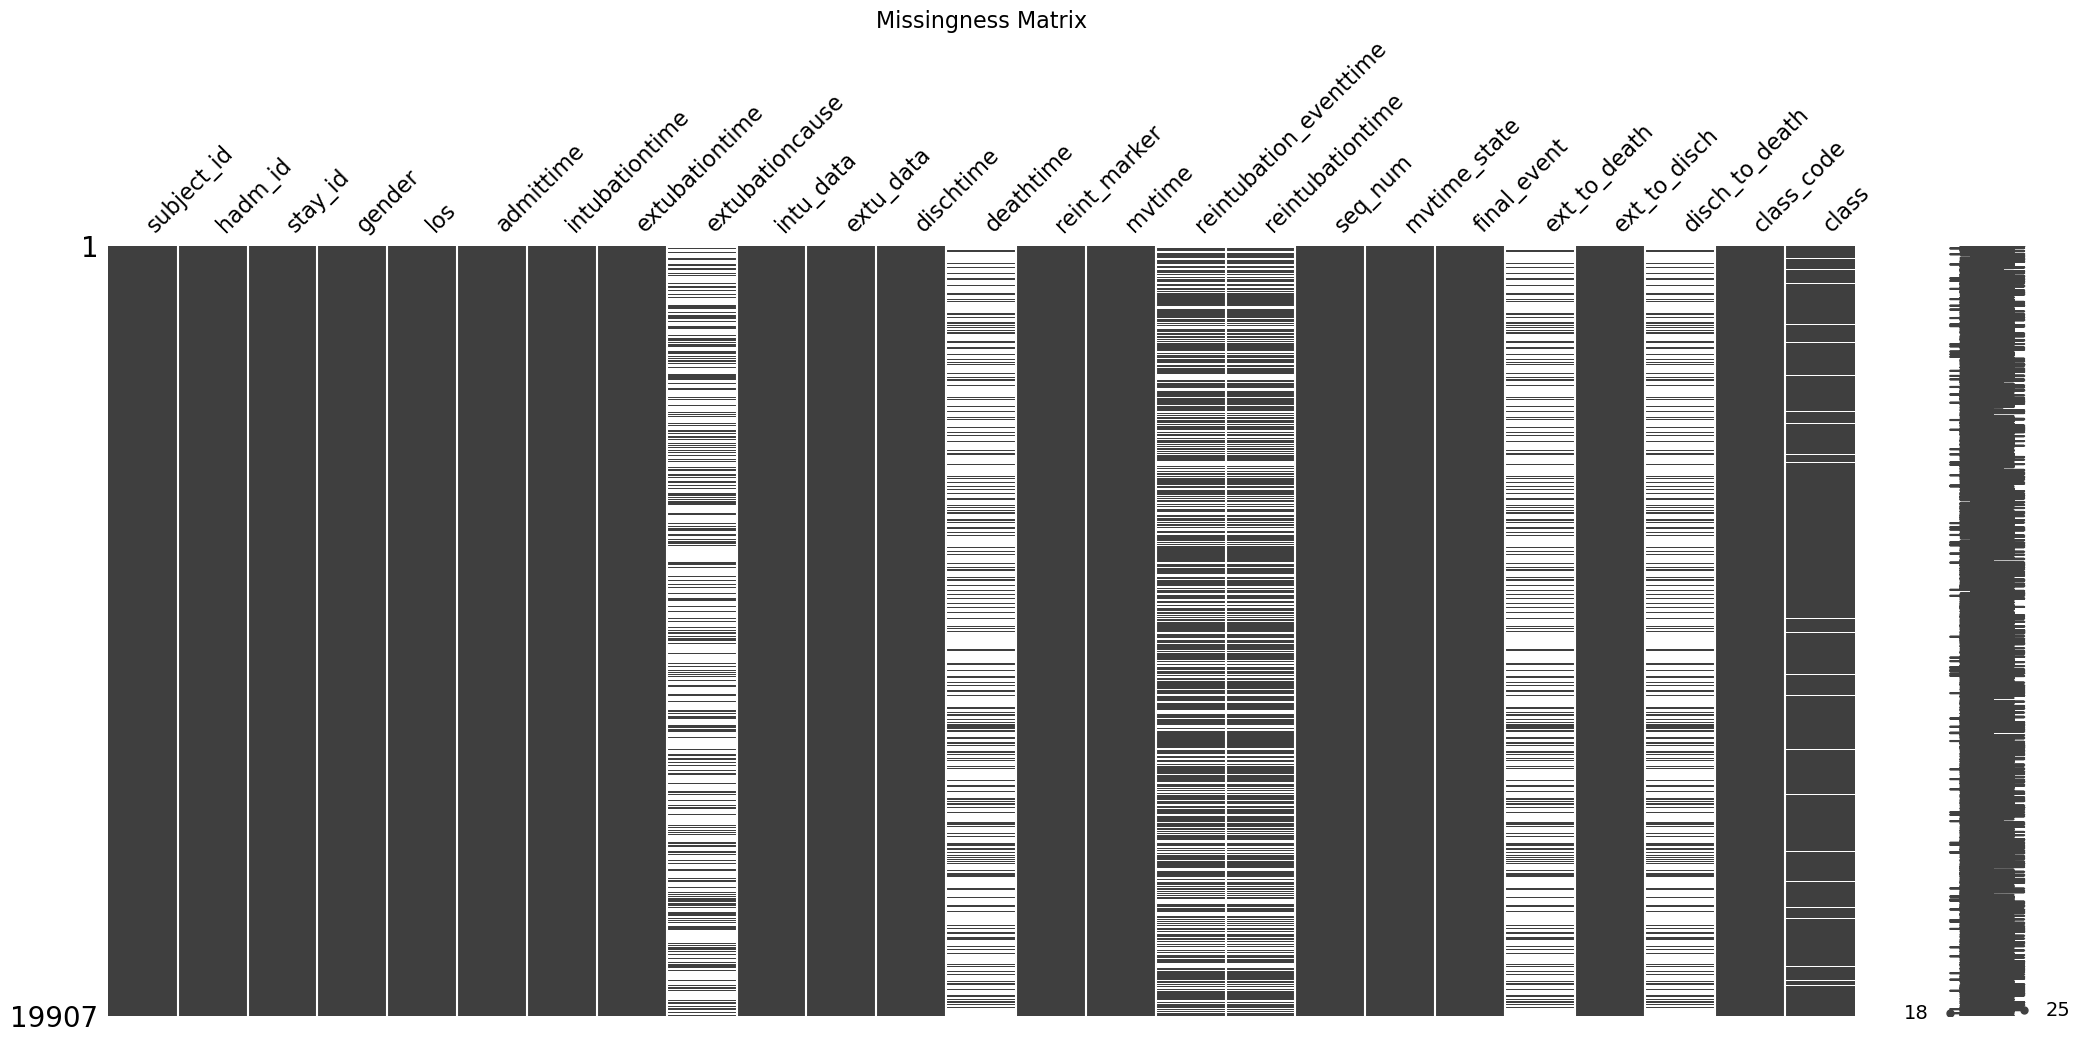

In [234]:
# 결측치 행렬 생성
plt.figure(figsize=(20, 10))
msno.matrix(subjectlist2_unable)
plt.title('Missingness Matrix', fontsize=16)
plt.show()

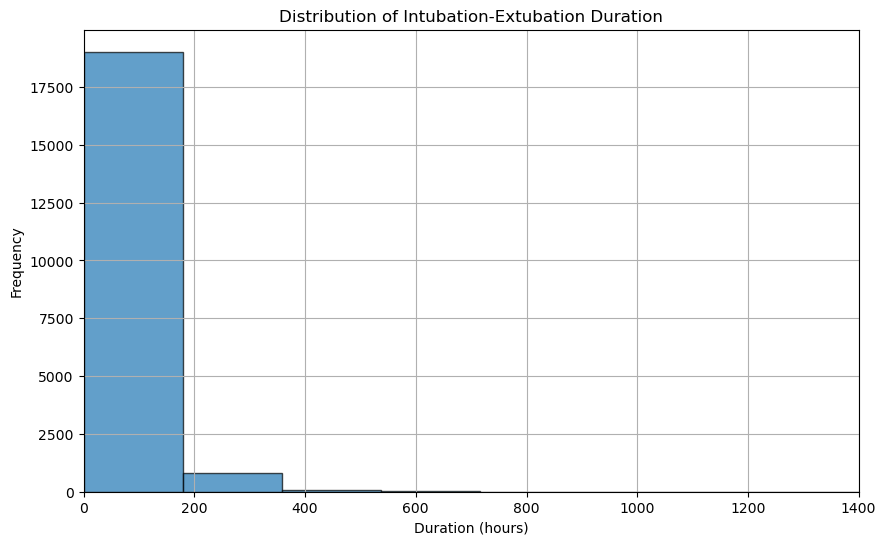

count    19907.000000
mean        46.624224
std         91.208179
min          0.016667
25%          7.733333
50%         21.000000
75%         59.933333
max       8944.000000
Name: duration, dtype: float64

In [181]:
# 삽관 기간의 분포 시각화
subjectlist2_unable.loc[:,'duration'] = (subjectlist2_unable.extubationtime - subjectlist2_unable.intubationtime).dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
subjectlist2_unable.duration.hist(bins = 50, edgecolor='k', alpha=0.7)
plt.title('Distribution of Intubation-Extubation Duration')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.xlim([0,1400])
plt.show()

subjectlist2_unable.duration.describe()

In [111]:
# 데이터 저장
sub2list_unable = subjectlist2_unable >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub2list_unable = sub2list_unable.drop_duplicates(subset='stay_id')   # remove dup

subjectlist2_unable.to_csv('./data/intubation_extubation_after_reconstruction.csv.csv')   # 삽관발관 포함 에러정의까지 한 파일?? 다 해결한 파일??
sub2list_unable.to_csv('./data/sub2list_unable.csv')   # 고유 환자리스트

NameError: name 'select' is not defined

In [ ]:
#   intubation_extubation_before_reconstruction(imputation).csv sub1
#   다해결이 되었으면 intubation_extubation_after_reconstruction.csv sub2